In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
# 新版已經改成獨立的 mplfinance 套件
# import matplotlib.finance as mpf

import mplfinance as mpf

In [2]:
# 讀入 data/tsla_df_dummies.csv
tsla_df = pd.read_csv("data/tsla_df_dummies.csv", index_col=0)

# 將 index 轉成 datetime
tsla_df.index = pd.to_datetime(tsla_df.index)

# 確認排序（很重要）
tsla_df = tsla_df.sort_index()

tsla_df.head()

,Close,High,Low,Open,Volume,date_weekday,netChangeRatio,positive
Date,,,,,,,,
2020-01-02,28.684000,28.713333,28.114000,28.299999,142981500,3,NaN,0
2020-01-03,29.534000,30.266666,29.128000,29.366667,266677500,4,2.963326,1
2020-01-06,30.102667,30.104000,29.333332,29.364668,151995000,0,1.925464,1
2020-01-07,31.270666,31.441999,30.224001,30.760000,268231500,1,3.880052,1
2020-01-08,32.809334,33.232666,31.215334,31.580000,467164500,2,4.920483,1


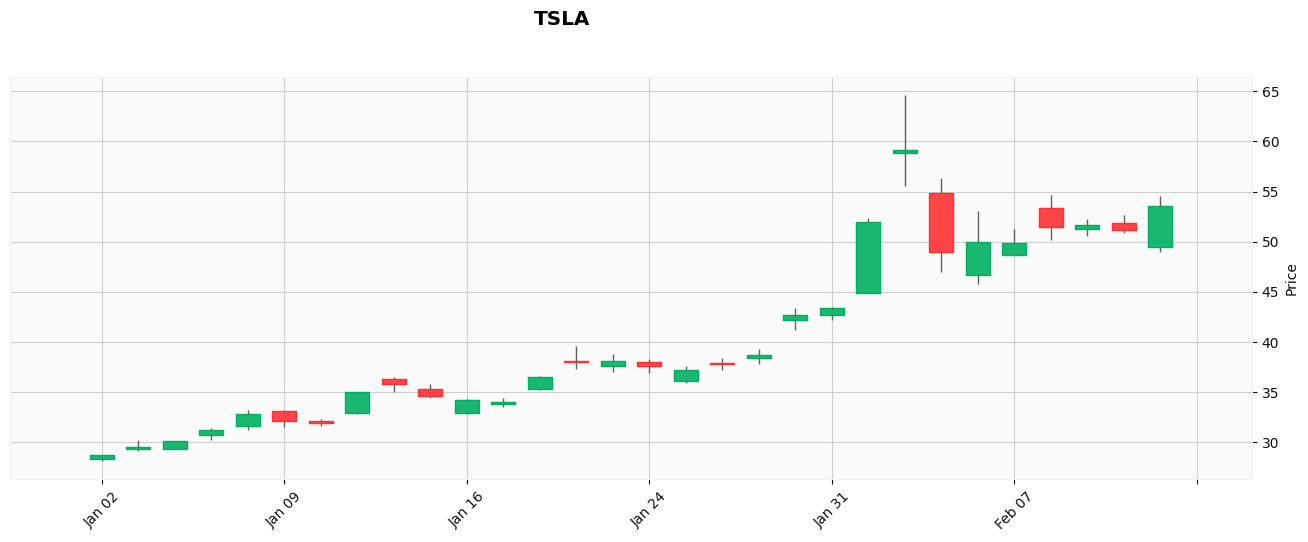

In [3]:
# 繪製K線圖
color_up  = "red"
color_down = "green"

tsla_df_example = tsla_df.iloc[:30]

mpf.plot(
    tsla_df_example,
    type="candle",
    style="yahoo",
    title="TSLA",
    ylabel="Price",
    figratio=(18, 6),
    
)

In [7]:
# 用bokeh繪製可互動的k線圖
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource
import pandas as pd

output_notebook()  # 讓圖顯示在 Jupyter Notebook

df = tsla_df[:30].copy()  # 保險用

source = ColumnDataSource(df)

# 設定 K 線顏色
inc = df.Close > df.Open
dec = df.Close < df.Open

p = figure(
    x_axis_type="datetime",
    width=900,
    height=450,
    title="TSLA Interactive Candlestick Chart",
    tools="pan,wheel_zoom,box_zoom,reset,save",
)

# 畫 K 線柱（最高-最低）
p.segment('Date', 'High', 'Date', 'Low', source=source, color="black")

# 畫向上 K 線（紅色）
p.vbar(df.index[inc], width=12*60*60*1000,  # 半天毫秒
       top=df.Close[inc], bottom=df.Open[inc],
       fill_color="red", line_color="red")

# 畫向下 K 線（綠色）
p.vbar(df.index[dec], width=12*60*60*1000,
       top=df.Open[dec], bottom=df.Close[dec],
       fill_color="green", line_color="green")

p.xaxis.axis_label = "Date"
p.yaxis.axis_label = "Price"

show(p)


Loading BokehJS ...

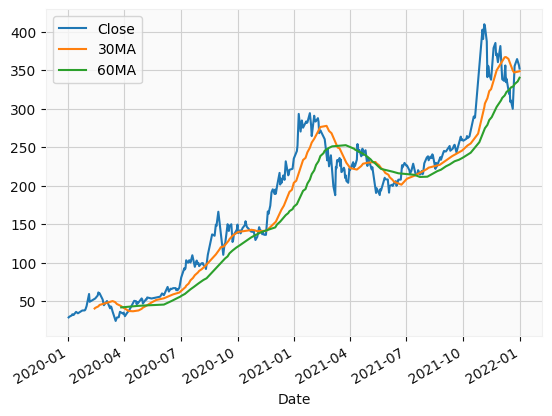

In [13]:
tsla_df.Close.plot()

# 30日平均移動線
tsla_df.Close.rolling(window=30).mean().plot()

# 60日 
tsla_df.Close.rolling(window=60).mean().plot()

plt.legend(['Close', '30MA', '60MA'], loc='best')

In [ ]:
# seaborn 在 matpllotlib 上封裝了更高級的 API，使作圖更容易與美觀
# 更多實用的方法再自己練習吧
import seaborn as sns


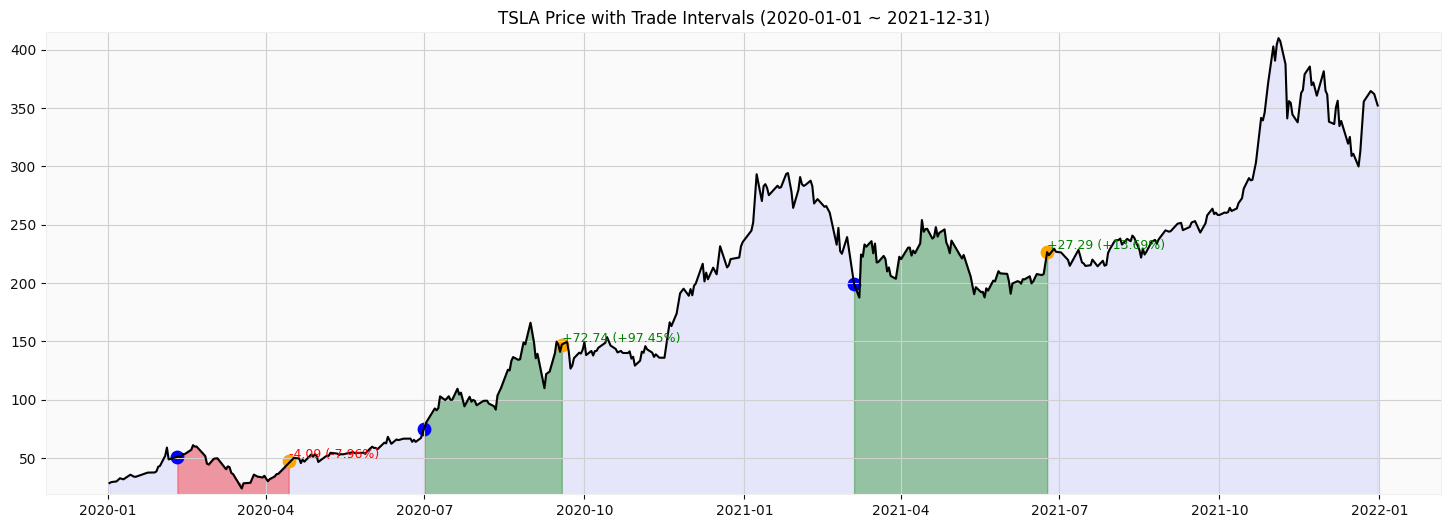

In [30]:
# 標示策略交易區間：假設執行一個量化交易策略，例如2020-05-01買入、2020-12-31賣出
# 初始化 + 畫基底線圖（只呼叫一次）
def plot_base(df, start='2020-01-01', end='2021-12-31'):
    start = pd.to_datetime(start)
    end = pd.to_datetime(end)

    sub = df.loc[start:end]

    plt.figure(figsize=(18, 6))
    plt.plot(sub.index, sub['Close'], color='black', label='Close')
    plt.fill_between(sub.index, 0, sub['Close'], color='blue', alpha=0.08)
    plt.title(f"TSLA Price with Trade Intervals ({start.date()} ~ {end.date()})")
    plt.ylim(sub['Close'].min() - 5, sub['Close'].max() + 5)

# 在同一張圖上疊加交易區間
def annotate_trade(df, buy_date, sell_date):
    # 找最近交易日
    buy_date = df.index.asof(pd.to_datetime(buy_date))
    sell_date = df.index.asof(pd.to_datetime(sell_date))

    buy_price = df.loc[buy_date, 'Close']
    sell_price = df.loc[sell_date, 'Close']

    pnl = sell_price - buy_price
    pnl_rate = pnl / buy_price * 100
    color = "green" if pnl > 0 else "red"

    # ✅ 正確區間遮罩（不會產生 IndexError）
    mask = (df.index >= buy_date) & (df.index <= sell_date)

    # 標示持有區間背景
    plt.fill_between(df.index[mask], 0, df['Close'][mask], color=color, alpha=0.35)

    # 買入與賣出標點
    plt.scatter(buy_date, buy_price, color='blue', s=80)
    plt.scatter(sell_date, sell_price, color='orange', s=80)

    # 盈虧文字提示
    plt.text(sell_date, sell_price,
             f"{pnl:+.2f} ({pnl_rate:+.2f}%)",
             color=color,
             fontsize=9,
             ha='left',
             va='bottom')

plot_base(tsla_df, '2020-01-01', '2021-12-31')

annotate_trade(tsla_df, '2020-02-10', '2020-04-14')
annotate_trade(tsla_df, '2020-07-01', '2020-09-18')
annotate_trade(tsla_df, '2021-03-05', '2021-06-24')

plt.show()